In [1]:
import os
import cv2 
import numpy as np

In [2]:
def list_images(basePath, validExts=(".jpg", ".jpeg"), contains=None):
    
    imagePaths = []

    # Boucle sur la structure de répertoire
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # Boucle sur les noms de fichiers dans le répertoire courant
        for filename in filenames:
            # Si la chaîne "contains" est définie et que le nom de fichier ne contient pas cette chaîne, ignorer le fichier
            if contains is not None and filename.find(contains) == -1:
                continue

            # Détermine l'extension de fichier du fichier courant
            ext = filename[filename.rfind("."):].lower()

            # Vérifie si le fichier est une image et doit être traité
            if ext.endswith(validExts):
                # Construit le chemin vers l'image et l'ajoute à la liste des chemins d'images
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)

    return imagePaths


In [3]:
#Initialisation des listes et dictionnaires utiles
poisson = ['ange', 'clown','goldfish','lion','scalaire','guppys','platys','discus','papillons','perroquets','kois']
dict = {'ange':0,'clown':1,'goldfish':2,'lion':3,'scalaire':4,'guppys':5,'platys':6,'discus':7,'papillons':8,'perroquets':9,'kois':10}
db = []
label = []

In [4]:
for poisson in poisson:

    # Récupérer la liste des chemins des images dans le dossier "new_data/[nom_poisson]"
    path = list_images('new_data/'+poisson)
    # Pour chaque image dans la liste des chemins
    for image in path:
        # Charger l'image en utilisant la librairie openCV
        im = cv2.imread(image)
        # Convertir l'image en tableau numpy
        im = np.array(im)
        # Ajouter le label correspondant au poisson à la liste des labels
        label.append(dict[poisson])
        # Ajouter l'image à la liste des données
        db.append(im)


# Convertir la liste des données et des labels en tableaux numpy
db = np.array(db)
label = np.array(label)

# Afficher la forme des tableaux de données et de labels
print(db.shape,label.shape)



(16500, 100, 100, 3) (16500,)


In [5]:
#normaliser les données
db=db.astype('float32')/255

In [6]:
from sklearn.model_selection import train_test_split
#Séparation du jeu de données en train et test 
xtrain, xtest, ytrain, ytest = train_test_split(db, label,test_size=0.3,random_state=42)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(11550, 100, 100, 3) (11550,) (4950, 100, 100, 3) (4950,)


In [7]:
# Importation de la classe OneHotEncoder depuis le module de prétraitement de scikit-learn
from sklearn.preprocessing import OneHotEncoder

# Initialisation de l'objet OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Redimensionnement des tableaux ytrain et ytest en tableaux 2D avec une colonne chacun
ytrain = ytrain.reshape(len(ytrain), 1)
ytest = ytest.reshape(len(ytest), 1)

# Appliquer l'encodage one-hot aux tableaux ytrain et ytest
ytrain = onehot_encoder.fit_transform(ytrain)
ytest = onehot_encoder.transform(ytest)

# Afficher la forme des tableaux encodés ytrain et ytest
print(ytrain.shape, ytest.shape)

(11550, 11) (4950, 11)


In [8]:
#Création du modèle
from keras import utils, layers, models, optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=(1,1),activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(dict), activation='softmax')) 


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-19 18:50:49.680849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-19 18:50:49.681458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 141376)            0         
                                                                 
 dense (Dense)               (None, 64)                9048128   
                                                                 
 dense_1 (Dense)             (None, 11)                715       
                                                        

In [ ]:
from keras.utils import plot_model
try:
    plot_model(model,to_file='model1.png',show_shapes=True,show_layer_names=True)
except:
    model.summary()

In [33]:
# Compilation du modèle avec une fonction de perte "categorical_crossentropy", 
# un optimiseur "adam" et une métrique d'évaluation "acc"
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle avec les données d'entraînement (xtrain, ytrain), 
# un batch size de 128, 100 époques et 20 steps_per_epoch, 
# les données de validation (xtest, ytest) et le EarlyStopping callback
history = model.fit(xtrain, ytrain, batch_size=100, epochs=100, steps_per_epoch=20, 
                    validation_data=(xtest, ytest))


Epoch 1/100


2023-01-19 18:37:19.055962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 3.3631 - acc: 0.1300

2023-01-19 18:37:26.920132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 13s 508ms/step - loss: 3.3631 - acc: 0.1300 - val_loss: 2.3050 - val_acc: 0.1525
Epoch 2/100
20/20 [==============================] - 8s 382ms/step - loss: 2.2151 - acc: 0.2135 - val_loss: 1.9961 - val_acc: 0.3457
Epoch 3/100
20/20 [==============================] - 7s 370ms/step - loss: 1.9828 - acc: 0.3285 - val_loss: 1.7858 - val_acc: 0.4055
Epoch 4/100
20/20 [==============================] - 7s 367ms/step - loss: 1.7819 - acc: 0.4060 - val_loss: 1.6463 - val_acc: 0.4483
Epoch 5/100
20/20 [==============================] - 7s 375ms/step - loss: 1.7018 - acc: 0.4215 - val_loss: 1.7309 - val_acc: 0.3980
Epoch 6/100
20/20 [==============================] - 8s 387ms/step - loss: 1.6210 - acc: 0.4421 - val_loss: 1.5531 - val_acc: 0.4671
Epoch 7/100
20/20 [==============================] - 7s 376ms/step - loss: 1.4123 - acc: 0.5200 - val_loss: 1.5487 - val_acc: 0.4822
Epoch 8/100
20/20 [==============================] - 7s 372ms/step - loss: 1.439

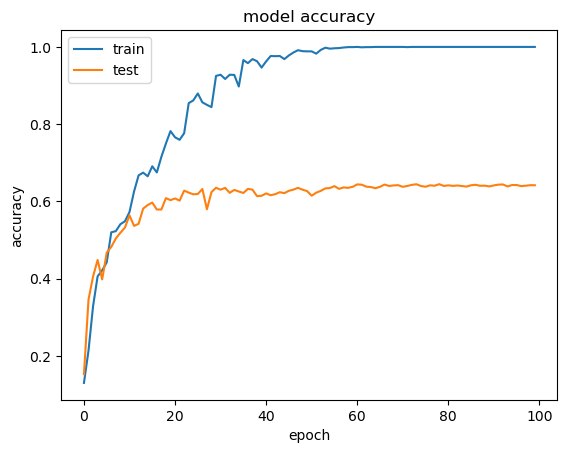

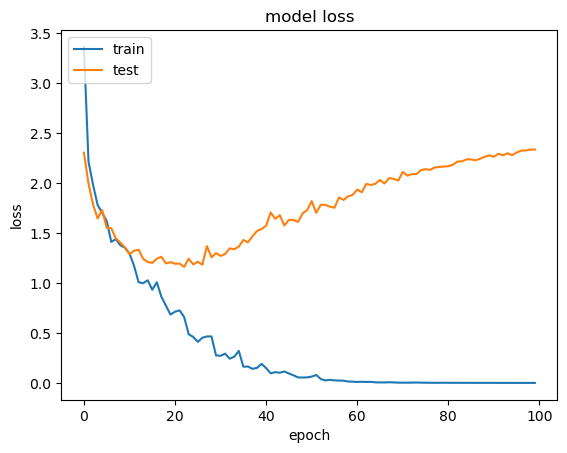

In [34]:
#Plotting des résultats d'accuracy du modèle

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#Plotting des résultats de loss du modèle
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
# Définition du nombre de steps pour l'évaluation sur les données de validation
validation_steps = 20

# Evaluation du modèle sur les données de validation (xtest, ytest) en utilisant validation_steps
loss0, accuracy0 = model.evaluate(xtest, ytest, steps=validation_steps)

# Affichage des résultats de l'évaluation
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 4s 167ms/step - loss: 2.3359 - acc: 0.6418
loss: 2.34
accuracy: 0.64


In [36]:
# Prédiction des résultats sur les données de test (xtest)
ypred = model.predict(xtest)

  3/155 [..............................] - ETA: 8s

2023-01-19 18:49:29.366767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - 10s 60ms/step


In [37]:
y_pred=np.argmax(ypred,axis=1)
y_test=np.argmax(ytest,axis=1)
print(y_pred.shape,y_test.shape)

(4950,) (4950,)


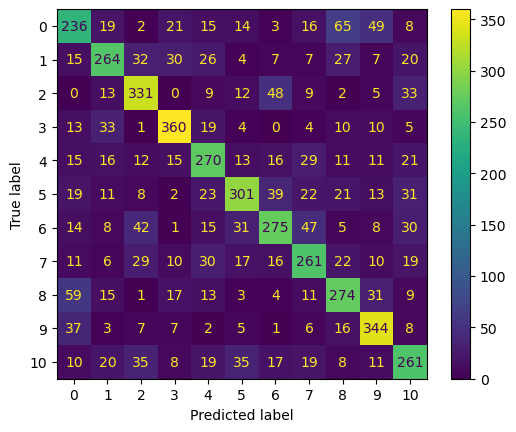

In [38]:
#Plotting de la matrice de confusion

from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay  
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix )
disp.plot()
plt.show()

#dict = {'ange':0,'clown':1,'goldfish':2,'lion':3,'scalaire':4,'guppys':5,'platys':6,'discus':7,'papillons':8,'perroquets':9,'kois':10}


In [9]:
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(11550, 100, 100, 3) (11550, 11) (4950, 100, 100, 3) (4950, 11)


In [10]:
# Utilisation de VGG16
# Import de keras de Tensorflow
from tensorflow import keras

# Chargement de la base de convolution VGG16 pré-entraînée en utilisant les poids imagenet
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(100, 100, 3))

In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [12]:
# Désactivation de la propriété trainable de conv_base pour empêcher l'entraînement
conv_base.trainable = False

# Création d'une couche de Flattening
layerFlatten = layers.Flatten()

# Création d'une couche dense avec 64 neurones et une fonction d'activation relu
layer0 = layers.Dense(4608, activation='relu')
drop0 = layers.Dropout(0.5)
layer1 = layers.Dense(64, activation='relu') 
drop1 = layers.Dropout(0.2)



# Création d'une couche de prédiction avec un nombre de neurones égal au nombre de classes
# et une fonction d'activation softmax
prediction_layer = layers.Dense(len(dict), activation='softmax')

# Création d'un modèle séquentiel en utilisant les couches précédemment définies
model = keras.Sequential([conv_base, layerFlatten,layer0,drop0, layer1,drop1, prediction_layer])


In [13]:
from keras.utils import plot_model
try:
    plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)
except:
    model.summary()

In [14]:
# Compilation du modèle avec une fonction de perte 'categorical_crossentropy', 
# un optimiseur 'adam' et une métrique d'évaluation 'acc'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
from tensorflow.keras.callbacks import EarlyStopping
# Initialisation d'un objet EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5)

# Entraînement du modèle avec les données d'entraînement (xtrain, ytrain), 
# un batch size de 126, 100 époques et 5 steps_per_epoch, 
# les données de validation (xtest, ytest) et 5 validation_steps,
# avec le EarlyStopping callback
history = model.fit(xtrain, ytrain, batch_size=100, epochs=100,
                    validation_data=(xtest, ytest),callbacks=[es])


2023-01-19 18:51:02.255538: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2023-01-19 18:51:04.922985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - ETA: 0s - loss: 1.9213 - acc: 0.3258

2023-01-19 18:52:03.927256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 84s 692ms/step - loss: 1.9213 - acc: 0.3258 - val_loss: 1.4502 - val_acc: 0.5000
Epoch 2/100
116/116 [==============================] - 81s 702ms/step - loss: 1.2612 - acc: 0.5558 - val_loss: 0.9903 - val_acc: 0.6741
Epoch 3/100
116/116 [==============================] - 87s 752ms/step - loss: 0.9563 - acc: 0.6604 - val_loss: 0.7271 - val_acc: 0.7632
Epoch 4/100
116/116 [==============================] - 83s 717ms/step - loss: 0.7907 - acc: 0.7144 - val_loss: 0.7480 - val_acc: 0.7519
Epoch 5/100
116/116 [==============================] - 80s 687ms/step - loss: 0.6480 - acc: 0.7670 - val_loss: 0.5994 - val_acc: 0.7990
Epoch 6/100
116/116 [==============================] - 80s 689ms/step - loss: 0.5634 - acc: 0.7986 - val_loss: 0.5512 - val_acc: 0.8174
Epoch 7/100
116/116 [==============================] - 80s 688ms/step - loss: 0.4677 - acc: 0.8327 - val_loss: 0.4899 - val_acc: 0.8360
Epoch 8/100
116/116 [==============================] - 82s 7

In [15]:
# Définition du nombre de steps pour l'évaluation sur les données de validation
validation_steps = 20

# Evaluation du modèle sur les données de validation (xtest, ytest) en utilisant validation_steps
loss0, accuracy0 = model.evaluate(xtest, ytest, steps=validation_steps)

# Affichage des résultats de l'évaluation
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))


20/20 [==============================] - 22s 1s/step - loss: 0.4225 - acc: 0.8943
loss: 0.42
accuracy: 0.89


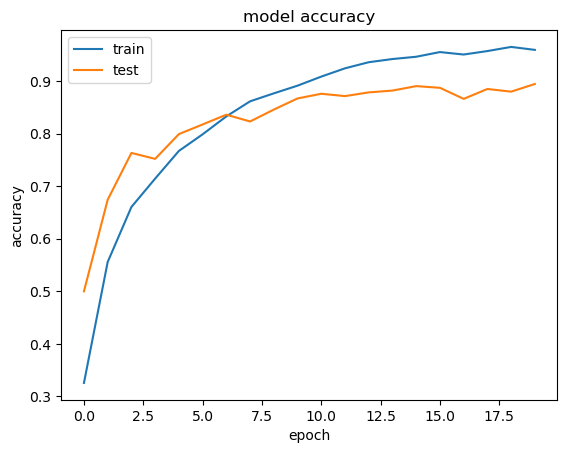

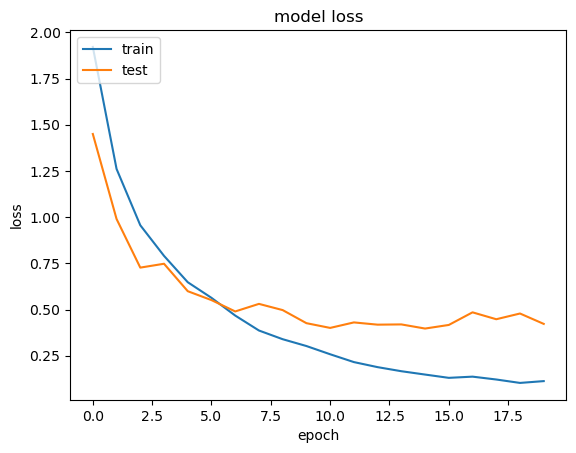

In [17]:
#Plotting de l'accuracy du modèle
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting de la courbe de perte d'entraînement et de validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# Prédiction des résultats sur les données de test (xtest)
ypred = model.predict(xtest)

2023-01-19 19:33:53.721912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - 20s 124ms/step


In [20]:
y_pred=np.argmax(ypred,axis=1)
#y_test=np.argmax(ytest,axis=1)
print(y_pred.shape,y_test.shape)

(4950,) (4950,)


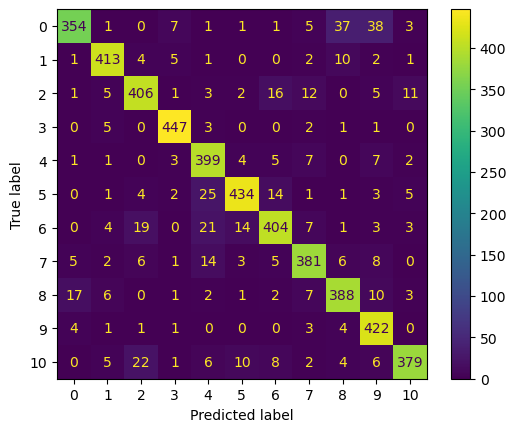

In [21]:
#Plotting de la matrice de confusion

from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay  
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix )
disp.plot()
plt.show()

#dict = {'ange':0,'clown':1,'goldfish':2,'lion':3,'scalaire':4,'guppys':5,'platys':6,'discus':7,'papillons':8,'perroquets':9,'kois':10}
